In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import chess
import  numpy as np
import board_util


2024-03-13 23:35:28.704100: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 23:35:28.743455: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 23:35:28.743480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 23:35:28.744647: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 23:35:28.751603: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-13 23:35:28.752094: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Read in data
file_path = "fen.txt"
data = []
with open(file_path, "r") as file:
    lines = file.readlines()

for line in lines:
    chessboard_state, move = line.split("[MOVESEP]")
    cb = chess.Board(chessboard_state)
    bb = board_util.board_to_bitboards(cb)
    ab = board_util.bitboards_to_array(bb)
   
    encoded_move = board_util.encode_move(move.strip(), ab)
    data.append((ab, encoded_move))

    



In [3]:
data[0][1]

array([1, 0, 3, 0, 0])

In [4]:
num_squares = 64
output_units_start_square = num_squares
output_units_end_square = num_squares

# CNN model
model = models.Sequential([
    tf.keras.Input(shape=(12, 8, 8)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
  
    # Output layers
    tf.keras.layers.Dense(num_squares, activation='softmax', name='output_start_square'),
    tf.keras.layers.Dense(num_squares, activation='softmax', name='output_end_square'),
    tf.keras.layers.Dense(num_squares, activation='softmax', name='output_piece')
])


# Compile the model with losses or metrics for the specified outputs
model.compile(optimizer='adam', 
              loss={'output_start_square': 'categorical_crossentropy', 
                    'output_end_square': 'categorical_crossentropy',
                    "output_piece": "categorical_crossentropy"}, 
              metrics={'output_start_square': 'accuracy', 
                       'output_end_square': 'accuracy',
                       "output_piece": "accuracy"})


print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 6, 32)         2336      
                                                                 
 max_pooling2d (MaxPooling2  (None, 5, 3, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 480)               0         
                                                                 
 dense (Dense)               (None, 64)                30784     
                                                                 
 output_start_square (Dense  (None, 64)                4160      
 )                                                               
                                                                 
 output_end_square (Dense)   (None, 64)                4

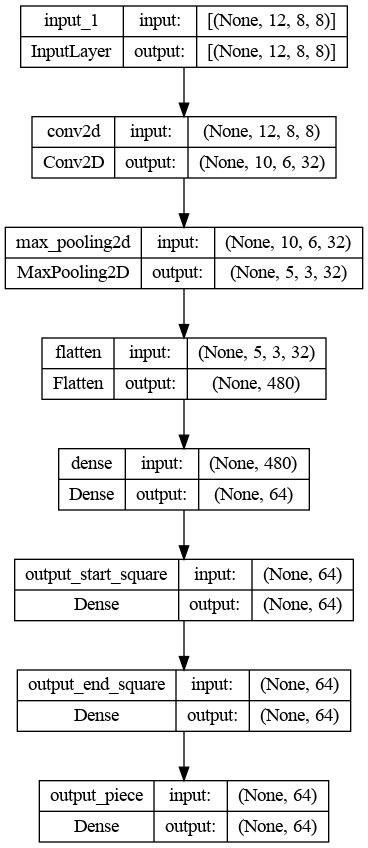

In [5]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import train_test_split


In [7]:


board = [item[0] for item in data]
move = [item[1] for item in data]

x_train, x_test, y_train, y_test = train_test_split(board, move, test_size=0.3, random_state=42)

# Convert lists to numpy arrays
x_train = np.array(x_train)
x_test = np.array(x_test)

# Convert moves to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# No need for one-hot encoding for the moves, as they are already encoded

y_train_start = y_train[:, :2]
y_train_end = y_train[:, 2:4]
y_train_piece = y_train[:, 4]

y_test_start = y_test[:, :2]
y_test_end = y_test[:, 2:4]
y_test_piece = y_test[:, 4]


checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)


In [15]:
print(y_train_piece)
print(len(y_train_piece))
print(y_train_piece[69])

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
70
0


: 

In [9]:
epochs = 5
batch_size = 64

history = model.fit(
    x_train,
    {'output_start_square': y_train_start, 'output_end_square': y_train_end, 'output_piece': y_train_piece},
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, {'output_start_square': y_test_start, 'output_end_square': y_test_end, 'output_piece': y_test_piece}),
    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback, reduce_lr_callback]
)




Epoch 1/5


ValueError: in user code:

    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 248, in __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 63, in _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    File "/home/jk/CityUSeattle/artificial_intel_for_data_sciecnce_DS510/team-project/chess_prediction_ml_ds510/venv/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 819, in map_to_output_names
        raise ValueError(

    ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['output_start_square', 'output_end_square']). Valid mode output names: ['output_piece']. Received struct is: {'output_start_square': <tf.Tensor 'IteratorGetNext:3' shape=(None, 2) dtype=int64>, 'output_end_square': <tf.Tensor 'IteratorGetNext:1' shape=(None, 2) dtype=int64>}.


In [ ]:

print("Shapes:")
print("xtrain:", np.array(xtrain).shape)
print("y_train_start_reshaped:", np.array(y_train_start_reshaped).shape)
print("y_train_end_reshaped:", np.array(y_train_end_reshaped).shape)
print("xtest:", np.array(xtest).shape)
print("ytest_startre_reshaped:", np.array(y_test_start_reshaped).shape)
print("ytest_end:", np.array(y_test_end_reshaped).shape)

print(model.summary())

print("Number of samples:")
print("xtrain:", len(xtrain))
print("xtest:", len(xtest))


In [ ]:
# Print labels for the first few samples
num_samples_to_print = 5
for i in range(num_samples_to_print):
    print("Sample", i+1, "label (y):", move[i])

